## Task

A simple yet powerful marketing technique is an analysis utilizing _recency_ (how recent was the customer's last purchase), _frequency_ (how often did the customer make a purchase in a given period) and _monetary_ (how much money did the customer spend in a given period) data to identify the best customers and perform targeted marketing campaigns. 

As data scientist you are asked to segment the customers using transaction data and profile them based-on their characteristics (recency, frequency, monetary). After you find the segments, name them using understandable words so marketing team can easily create campaign strategies.

**Data:**
`../data/transactions.csv`

**Hints:** 
For each customer id, generate time difference between their last transaction and today. You should also calculate number of transaction and total amount of spending. You are allowed to use SQL.

**Output:**
Push the *executed* notebook into your github repo and submit the URL to ketua kelas no later than August 21, 2021. Note that notebook must contain explanatory analysis and clustering as well as story about your findings.

**Goodluck!**



In [118]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

import time, warnings
import datetime as dt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

In [139]:
# The code was removed by Watson Studio for sharing.

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   customer_id   125000 non-null  object
 1   trans_date    125000 non-null  object
 2   trans_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [141]:
df.describe()

,trans_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


In [142]:
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

customer_id     0.0
trans_date      0.0
trans_amount    0.0
dtype: float64

In [144]:
# Membuat atribut baru : Monetary
df['monetary'] = df['trans_amount']
rfm_m = df.groupby('customer_id')['monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,customer_id,monetary
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857


In [145]:
# Membuat atribut baru : Frequency
rfm_f = df.groupby('customer_id')['trans_date'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['customer_id', 'frequency']
rfm_f.head()

,customer_id,frequency
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13


In [146]:
# Menggabungkan (merging) dua dataframe
rfm = pd.merge(rfm_m, rfm_f, on='customer_id', how='inner')
rfm.head()

,customer_id,monetary,frequency
0,CS1112,1012,15
1,CS1113,1490,20
2,CS1114,1432,19
3,CS1115,1659,22
4,CS1116,857,13


In [150]:
# Membuat atribut baru : Recency
df['trans_date'] = pd.to_datetime(df['trans_date'],format='%d-%b-%y', errors='coerce')

In [159]:
df['datenow'] = dt.date(2021,9,28)
df['datenow'] = pd.to_datetime(df['datenow'])
df.head()

,customer_id,trans_date,trans_amount,Monetary,monetary,datenow,diff
0,CS5295,2018-02-11,35,35,35,2021-09-28,NaT
1,CS4768,2020-03-15,39,39,39,2021-09-28,NaT
2,CS2122,2018-02-26,52,52,52,2021-09-28,NaT
3,CS1217,2016-11-16,99,99,99,2021-09-28,NaT
4,CS1850,2018-11-20,78,78,78,2021-09-28,NaT


In [160]:
# Menghitung selisih antara datenow dengan trans_date
df['diff'] = df['datenow'] - df['trans_date']
df.head()

,customer_id,trans_date,trans_amount,Monetary,monetary,datenow,diff
0,CS5295,2018-02-11,35,35,35,2021-09-28,1325 days
1,CS4768,2020-03-15,39,39,39,2021-09-28,562 days
2,CS2122,2018-02-26,52,52,52,2021-09-28,1310 days
3,CS1217,2016-11-16,99,99,99,2021-09-28,1777 days
4,CS1850,2018-11-20,78,78,78,2021-09-28,1043 days


In [162]:
rfm_r = df.groupby('customer_id')['diff'].min()
rfm_r = rfm_r.reset_index()
rfm_r.head()

,customer_id,diff
0,CS1112,623 days
1,CS1113,597 days
2,CS1114,594 days
3,CS1115,572 days
4,CS1116,765 days


In [163]:
# Menggabungkan dataframe 
rfm = pd.merge(rfm, rfm_r, on='customer_id', how='inner')
rfm.columns = ['customer_id', 'monetary', 'frequency', 'recency']
rfm.head()

,customer_id,monetary,frequency,recency
0,CS1112,1012,15,623 days
1,CS1113,1490,20,597 days
2,CS1114,1432,19,594 days
3,CS1115,1659,22,572 days
4,CS1116,857,13,765 days


In [165]:
# Extract jumlah hari
rfm['recency'] = rfm['recency'].dt.days
rfm.head()

,customer_id,monetary,frequency,recency
0,CS1112,1012,15,623
1,CS1113,1490,20,597
2,CS1114,1432,19,594
3,CS1115,1659,22,572
4,CS1116,857,13,765


In [166]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6889 entries, 0 to 6888
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6889 non-null   object
 1   monetary     6889 non-null   int64 
 2   frequency    6889 non-null   int64 
 3   recency      6889 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 269.1+ KB


In [167]:
#Standardized Variable
X = rfm.drop(['customer_id'], axis=1)

standardize = StandardScaler()
X_std = pd.DataFrame(standardize.fit_transform(X))
X_std.columns = X.columns

In [168]:
#K-Means: with 2 variables with speculated K
X_is = X_std[['monetary' , 'recency']].values

In [169]:
k = 4
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_is)

centroids = k_means.cluster_centers_

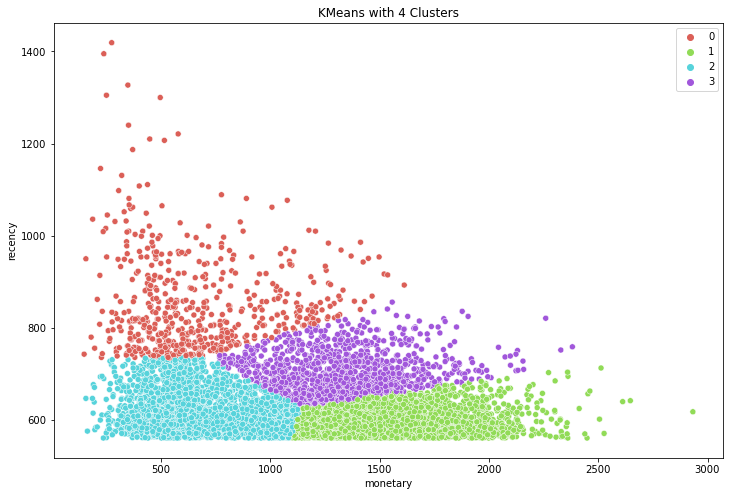

In [171]:
Segment = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['monetary'], X['recency'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

In [172]:
centroids = X[['monetary','recency']].groupby(Segment, as_index=False).mean()
centroids

,monetary,recency
0,672.805505,853.240367
1,1549.092400,596.451958
2,706.235017,618.305805
3,1319.595315,701.402262


In [173]:
#K-Means (2): 2 Variables with Elbow Method and Silhouette to Determine k
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

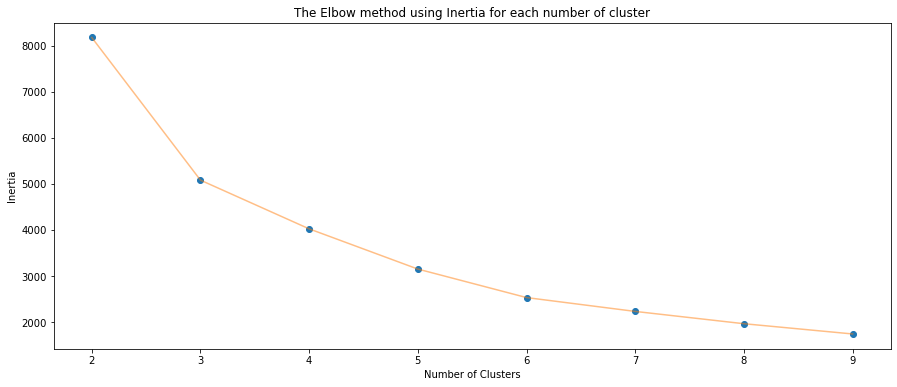

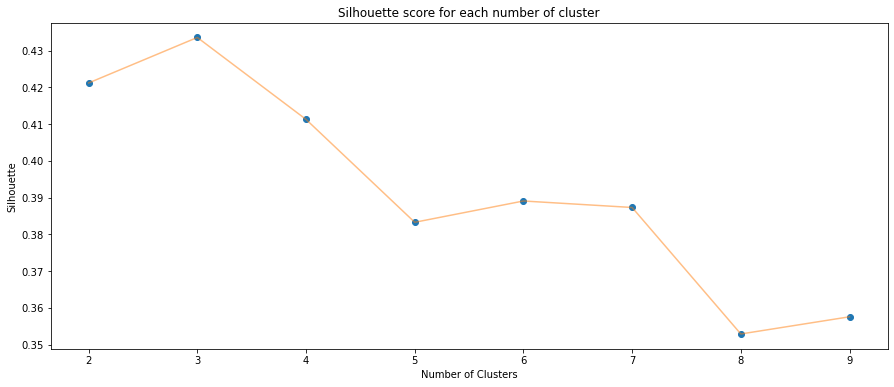

In [174]:
inertia, silhouette = k_means_inertia_silhouette(X = X_is)

In [175]:
k = 3
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_is)

KMeans(n_clusters=3, random_state=123)

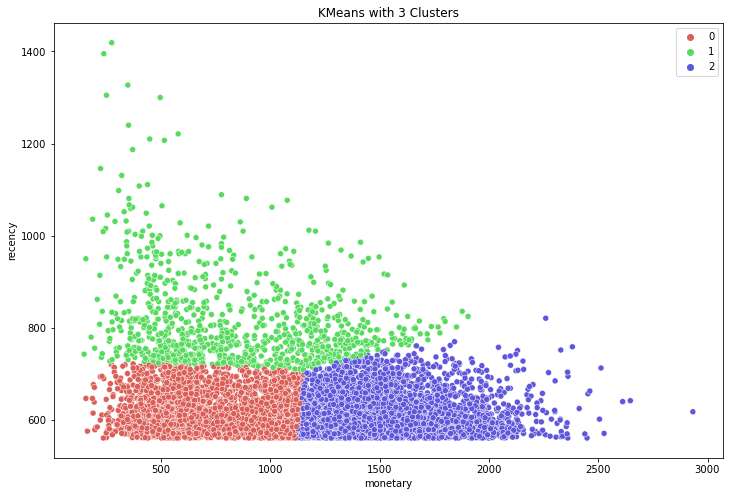

In [176]:
Segment = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['monetary'], X['recency'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

In [177]:
centroids = X[['monetary','recency']].groupby(Segment, as_index=False).mean()
centroids

,monetary,recency
0,739.460827,620.209947
1,863.280088,812.688184
2,1527.112071,613.888739


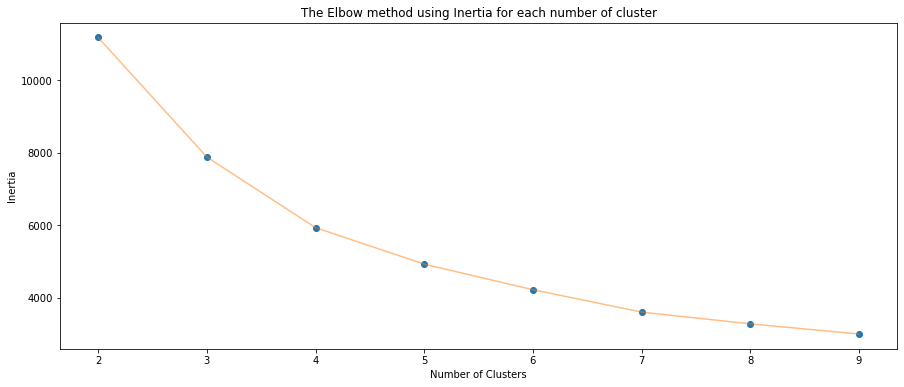

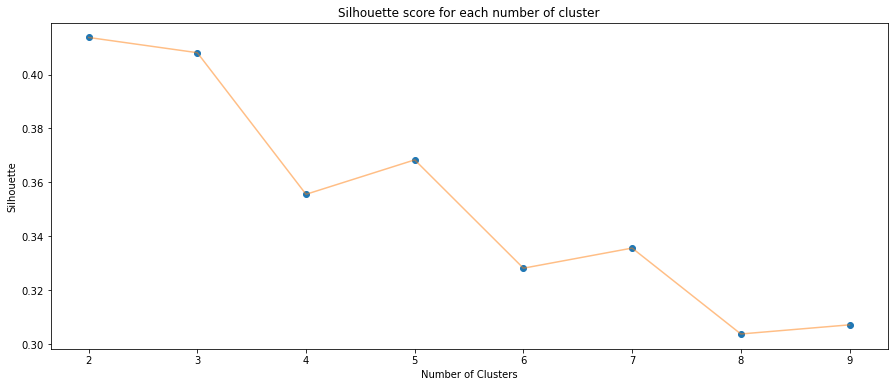

In [178]:
#K-Means (3): 3 Variables with Elbow Method and Silhouette to Determine k
inertia, silhouette = k_means_inertia_silhouette(X_std, k_max = 10, init = 'k-means++')

In [179]:
k = 5
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_std)

KMeans(n_clusters=5, random_state=123)

In [180]:
Segment = k_means.labels_
X.groupby(Segment, as_index=False).mean()

,monetary,frequency,recency
0,635.904298,12.664756,628.771920
1,1768.267434,24.996801,607.206014
2,1278.687768,18.786481,724.425966
3,605.606061,11.692308,869.433566
4,1260.807207,18.605856,599.424324


In [181]:
X['Segment'] = list(map(str, Segment))
fig = px.scatter_3d(X, x='monetary', y='frequency', z='recency', color='Segment',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 